In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
with open("gsm8k_diffllms_merged.json") as f:
    data = json.load(f)

In [4]:
df = pd.DataFrame(data)

In [6]:
data[0]

{'model': 'flant5',
 'metadata_example_idx': 0,
 'question': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?",
 'gold': "Step 1 - Janet eats 3 duck eggs for breakfast and bakes 4 into muffins so 3 + 4 = <<3+4=7>>7 duck eggs are used. Step 2 - Each day Janet's ducks lay 16 eggs and she uses 7, 16 - 7 = <<16-7=9>>9 duck eggs are for sale. Step 3 - She sells her eggs for $2 per egg and has 9 available for sale so 2 * 9 = $<<2*9=18>>18 per day. Step 4 - A: 18",
 'cot': "Solution: Janet eats 3 eggs for breakfast and 4 for muffins so she has 3 + 4 = 7 eggs. She sells the remaining eggs at the farmers' market for $2 per egg so she makes 2 * 7 = $14. She makes $14 every day at the farmers' market. Answer: 14.",
 'step_metrics': [{'step_text': 'Janet eats 3 eggs fo

In [76]:
df_data = []
for item in data:
    d = {"model": item["model"], "idx": item["metadata_example_idx"]}
    for step in item["step_metrics"]:
        for key in step:
            d[key] = step[key]
        df_data.append(d.copy())
df = pd.DataFrame(df_data)

In [77]:
df = df[df["Coherency"]!=""].reset_index(drop=True)

In [78]:
set(range(120)) - set(df["idx"].unique())

{27, 30, 38, 43, 44, 53, 54, 81, 82, 83, 84, 85, 86, 87, 88, 89}

In [79]:
error_types = ['Grammar', 'Coherency', 'Hallucination', 'Missing step', 'Repetition', 'Factuality', 'Redundancy', 'Commonsense', 'Arithmetic']

In [80]:
df[error_types] = df[error_types].replace({"yes": 1 , "no": 0, "": 0}).astype(int)

In [81]:
df.groupby(["model"], as_index=False)["idx"].nunique()

,model,idx
0,chatgpt,29
1,flant5,25
2,llama70b,23
3,vicuna,27


In [123]:
step_wise_model_stats = {}
for model, model_df in df.groupby("model"):
    total_steps = model_df.shape[0]
    total_erros_by_type = model_df[error_types].sum()
    step_wise_model_stats[model] = total_erros_by_type.to_dict()
    step_wise_model_stats[model]["total_steps"] = total_steps
    step_wise_model_stats[model]["model_name"] = model
    steps_error_count = model_df.groupby(["model", "idx"], as_index=False)[error_types].sum()[error_types].sum(axis=1)
    step_wise_model_stats[model]["total_questions"] = len(steps_error_count)
    step_wise_model_stats[model]["questions_with_error"] = sum(steps_error_count > 0)

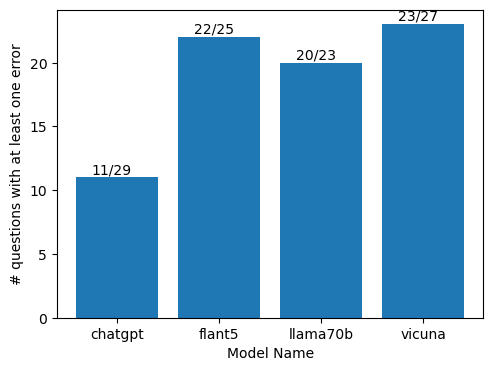

In [124]:
wrongly_answered_questions = {model: step_wise_model_stats[model]["questions_with_error"] for model in step_wise_model_stats}
fig = plt.figure(figsize=(5.5, 4))
plt.bar(wrongly_answered_questions.keys(), wrongly_answered_questions.values())
# plt.title("Total Number of questions with at least one error", fontsize=15)
plt.xlabel("Model Name")
plt.ylabel("# questions with at least one error")
for i, model in enumerate(wrongly_answered_questions):
    plt.text(i-0.25, wrongly_answered_questions[model]+0.3, f"{wrongly_answered_questions[model]}/{step_wise_model_stats[model]['total_questions']}")

In [150]:
most_common_error_types = {}
tok_k = 3
for model in step_wise_model_stats:
    errors_dict = {k: step_wise_model_stats[model][k] for k in error_types} 
    top_errors = sorted(errors_dict.items(), key = lambda item: item[1], reverse=True)
    top_errors = top_errors[0:tok_k]
    most_common_error_types[model] = {k:v for k,v in top_errors}
    # most_common_error_types[model]["totel_steps"] = step_wise_model_stats[model]["total_steps"]

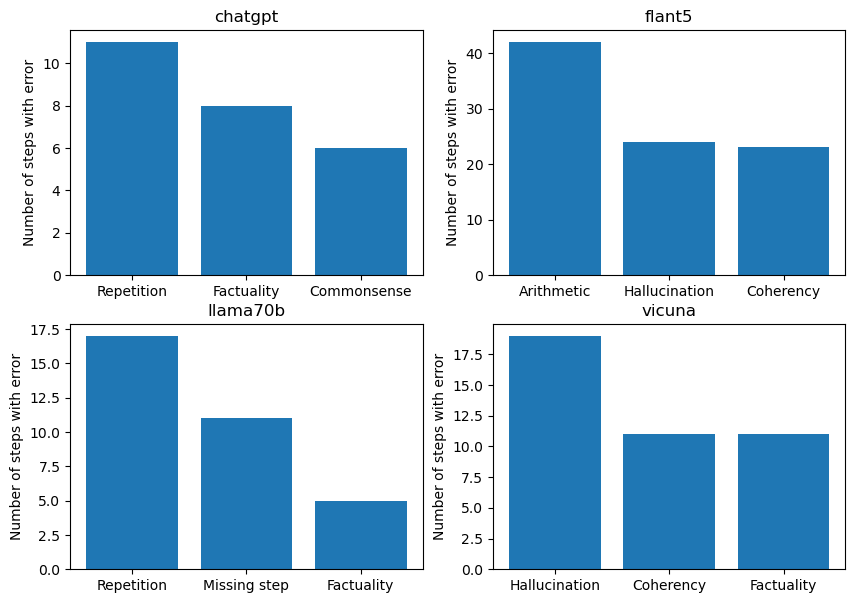

In [176]:
fig = plt.figure(figsize=(10,7))
for i, model in enumerate(most_common_error_types):
    ax1 = plt.subplot(220+i+1)
    ax1.bar(most_common_error_types[model].keys(), most_common_error_types[model].values())
    ax1.set_title(model, fontsize=12)
    ax1.set_ylabel("Number of steps with error")
plt.savefig("error_analysis.png", bbox_inches="tight")

In [166]:
least_common_error_types = {}
tok_k = 3
for model in step_wise_model_stats:
    errors_dict = {k: step_wise_model_stats[model][k] for k in error_types} 
    top_errors = sorted(errors_dict.items(), key = lambda item: item[1], reverse=False)
    top_errors = top_errors[0:tok_k]
    least_common_error_types[model] = {k:v for k,v in top_errors}
    # most_common_error_types[model]["totel_steps"] = step_wise_model_stats[model]["total_steps"]

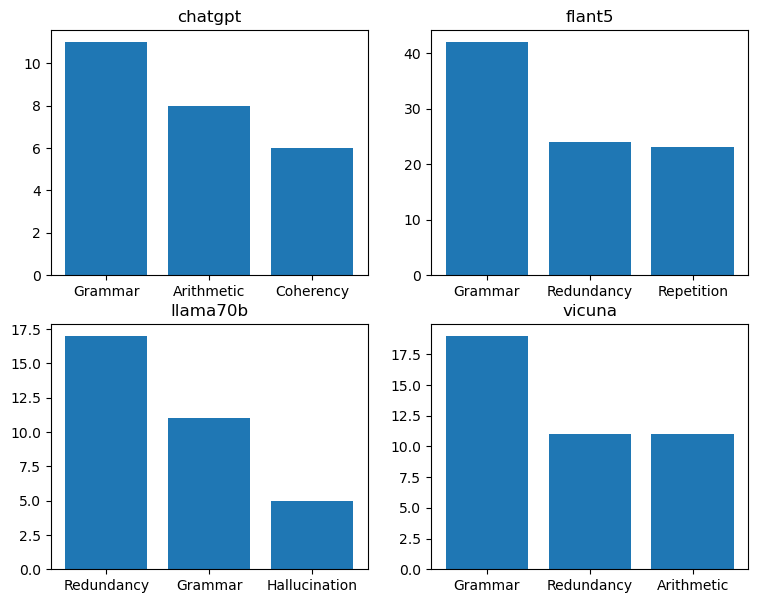

In [167]:
fig = plt.figure(figsize=(9,7))
for i, model in enumerate(most_common_error_types):
    ax1 = plt.subplot(220+i+1)
    ax1.bar(least_common_error_types[model].keys(), most_common_error_types[model].values())
    ax1.set_title(model, fontsize=12)